### Урок 4. Кейс 1. Построение и оценка модели#

### -- Автор: Шенк Евгений Станиславович

###  Вариант 1
Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns
import pandas_profiling
import datetime
import itertools
import lightgbm as lgbm

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import os

import warnings
warnings.filterwarnings("ignore") # отключает предупреждения

In [2]:
# Фукция для выявления важных признаков при работе lightGBM
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [3]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def split_data_b(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [6]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [7]:
data_W = data.resample("W").mean()

In [8]:
data_W.head(3)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.0,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.0,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.0,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000


In [9]:
# Убираем неинформативные признаки
data_W.drop(columns=['hour', 'dayofyear', 'dayofweek'], inplace=True)

Text(0, 0.5, 'Количество')

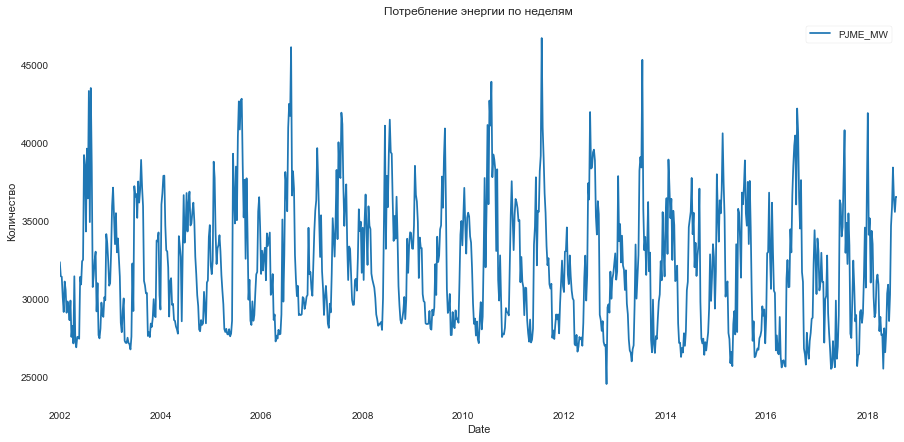

In [10]:
data_W['PJME_MW'].plot(figsize = ( 15, 7 ), title = 'Потребление энергии по неделям' )
plt.legend()
plt.ylabel ('Количество')

In [11]:
 # добавили историю на глубину p измерения от текущего
p=10

for x in range(1, p+1):
    data_W[f't{x}'] = 0.0
    data_W[f't{x}'].iloc[x:]=data_W['PJME_MW'].iloc[:-x].values

# добавили сглаживание
data_W['exp_0_01'] = 0
data_W['exp_0_01'] = exponential_smoothing(data_W['PJME_MW'], 0.01)
data_W['exp_0_03'] = 0
data_W['exp_0_03'] = exponential_smoothing(data_W['PJME_MW'], 0.03)
data_W['exp_0_05'] = 0
data_W['exp_0_05'] = exponential_smoothing(data_W['PJME_MW'], 0.05)
data_W['exp_0_08'] = 0
data_W['exp_0_08'] = exponential_smoothing(data_W['PJME_MW'], 0.8)
data_W['exp_0_12'] = 0
data_W['exp_0_12'] = exponential_smoothing(data_W['PJME_MW'], 0.12)
data_W['exp_0_15'] = 0
data_W['exp_0_15'] = exponential_smoothing(data_W['PJME_MW'], 0.15)

# добавим разности - 1-й порядок
data_W['diff1'] = 0.0
data_W['diff1'].iloc[1:] = data_W['PJME_MW'].iloc[:-1].values - data_W['PJME_MW'].iloc[1:].values

first_diff_d = data_W['diff1'].iloc[1:] / data_W.iloc[1:,0].values
data_W['diff1_d'] = 0
data_W['diff1_d'] =  data_W['diff1_d'].astype('float') 
data_W['diff1_d'].values[1:] = np.array(first_diff_d).astype('float32')

# Добавим скользящее среднее по всей модели с глубиной:
data_W['d_w4'] = data_W['PJME_MW'].rolling(window=4).mean() #1 мес
data_W['d_w9'] = data_W['PJME_MW'].rolling(window=9).mean() #2 мес
data_W['d_w26']= data_W['PJME_MW'].rolling(window=26).mean() #6 мес

data_W.fillna(0, inplace=True)

In [12]:
# Добавляем признаки методом главных компонент
scl=StandardScaler()
Xscale = scl.fit_transform(data_W.iloc[:,:-1].values)
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])

data_W['pca1'] = 0
data_W['pca1'] = Xpca[:,0]
data_W['pca1'] = 0
data_W['pca2'] = Xpca[:,1]

### Отбор признаков:

In [13]:
h=1
scl_x=StandardScaler() 
X = data_W.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

scl_target=StandardScaler() 
target = data_W['PJME_MW'].values[h+p:].reshape((data_W.shape[0]-h-p,1))
y = scl_target.fit_transform(target)

f_test, _ = f_regression(X, y.ravel())
f_test /= np.nanmax(f_test)
for i in range(X.shape[1]):
    print(f'F-test={f_test[i]},  I={i}')

F-test=0.9647858679021111,  I=0
F-test=0.006617454290281264,  I=1
F-test=0.0015814347443241432,  I=2
F-test=1.3597883197655166e-05,  I=3
F-test=0.0013821074032931938,  I=4
F-test=0.0017275534406800068,  I=5
F-test=0.0013183826588422571,  I=6
F-test=0.0034217872500571676,  I=7
F-test=0.0013183826588422571,  I=8
F-test=0.5092387329853825,  I=9
F-test=0.29483510134380797,  I=10
F-test=0.15380362552631754,  I=11
F-test=0.06599671443845319,  I=12
F-test=0.01618208159298272,  I=13
F-test=1.6465890434398996e-06,  I=14
F-test=0.014080836057968879,  I=15
F-test=0.056693692902653026,  I=16
F-test=0.12091477639559925,  I=17
F-test=0.18628217370928696,  I=18
F-test=0.007498992106927139,  I=19
F-test=0.012436806470540981,  I=20
F-test=0.022200521376770373,  I=21
F-test=1.0,  I=22
F-test=0.09835463705307725,  I=23
F-test=0.14748622359925004,  I=24
F-test=0.016120752575871714,  I=25
F-test=0.014826960753116325,  I=26
F-test=0.5784987522996289,  I=27
F-test=0.09509186976574953,  I=28
F-test=0.00510815

In [14]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
column_names = data_W.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 't1', 'exp_0_08', 'd_w4', 'pca2'], dtype='object')

In [15]:
sfp=SelectPercentile(f_regression, percentile=20)
X_new2 = sfp.fit_transform(X, y.ravel())
column_namesp = data_W.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 't1', 't2', 't10', 'exp_0_08', 'd_w4', 'pca2'], dtype='object')

#### column_namesp содержит все признаки из column_names, поэтому оставим его и запустим lightGBM для еще одного отбора признаков

In [16]:
# Гиперпараметры подбирались с помощью GridSearchCV ниже.
model_lgbm = lgbm.LGBMRegressor(learning_rate = 0.01,
                                num_leaves=7, 
                                n_estimators = 500,
                                subsample = 1,
                                reg_alpha = 20,
                                reg_lambda = 20,
                                n_jobs = -1,
                                random_state = 21)

In [17]:
model_lgbm.fit(X, y) 
Y_pred_gb = model_lgbm.predict(X)

er_r2 = r2_score(y_true=y, y_pred=Y_pred_gb)

print('r2 score :  ', er_r2, '%')

r2 score :   0.7541426358859185 %


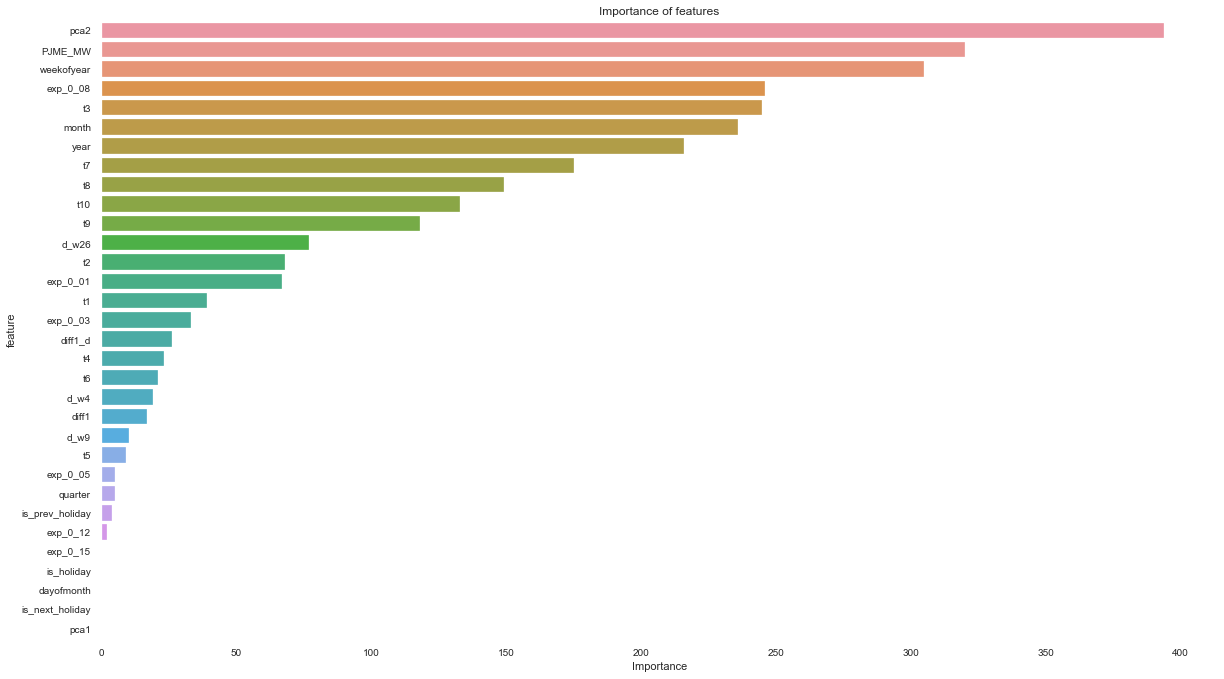

In [18]:
important_features_top = show_feature_importances(data_W.columns, model_lgbm.feature_importances_, get_top=7)

In [19]:
important_features_top

['pca2', 'PJME_MW', 'weekofyear', 'exp_0_08', 't3', 'month', 'year']

In [20]:
column_namesp

Index(['PJME_MW', 't1', 't2', 't10', 'exp_0_08', 'd_w4', 'pca2'], dtype='object')

In [21]:
# Возьмем все важные признаки
total_imp_features = ['pca2', 'PJME_MW', 'weekofyear', 'exp_0_08', 't3', 'month', 'year', 't1', 't2', 't10', 'd_w4']

In [22]:
train_b, test_b = split_data_b(data_W[total_imp_features], '12/31/2015')

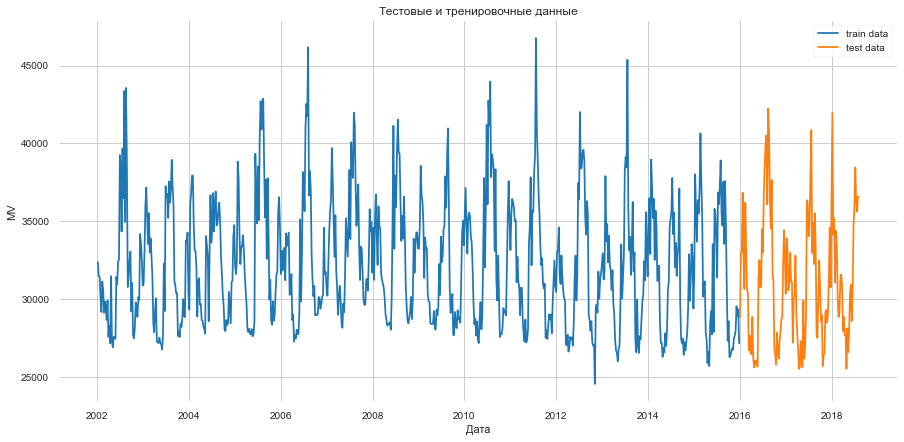

In [23]:
X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b['PJME_MW'].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b['PJME_MW'].values[1:]

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Дата')
plt.ylabel('MV')
plt.plot(train_b.index.get_level_values('Date'), train_b['PJME_MW'], label='train data' )
plt.plot(test_b.index.get_level_values('Date'), test_b['PJME_MW'], label='test data')

plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.grid()
plt.show()

In [24]:
model_lgbm = lgbm.LGBMRegressor(learning_rate = 0.01,
                                num_leaves=7, 
                                n_estimators = 500,
                                subsample = 1,
                                reg_alpha = 5,
                                reg_lambda = 5,
                                n_jobs = -1,
                                random_state = 21)

In [25]:
"""params = {'n_estimators':[100, 250, 500, 750, 1000], 
          'num_leaves':[6, 7, 8, 9, 10],
          'learning_rate':[0.01, 0.02],
          'reg_alpha':[0, 5, 10, 20],
          'reg_lambda':[0, 5, 10, 20]}

cv=KFold(n_splits=2, random_state=21, shuffle=True)

rs = GridSearchCV(model_lgbm, params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
rs.fit(X_train_b, y_train_b)"""

"params = {'n_estimators':[100, 250, 500, 750, 1000], \n          'num_leaves':[6, 7, 8, 9, 10],\n          'learning_rate':[0.01, 0.02],\n          'reg_alpha':[0, 5, 10, 20],\n          'reg_lambda':[0, 5, 10, 20]}\n\ncv=KFold(n_splits=2, random_state=21, shuffle=True)\n\nrs = GridSearchCV(model_lgbm, params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)\nrs.fit(X_train_b, y_train_b)"

In [26]:
"""rs.best_params_"""

'rs.best_params_'

### модель предсказания 1-й точки от текущей (h = 1)

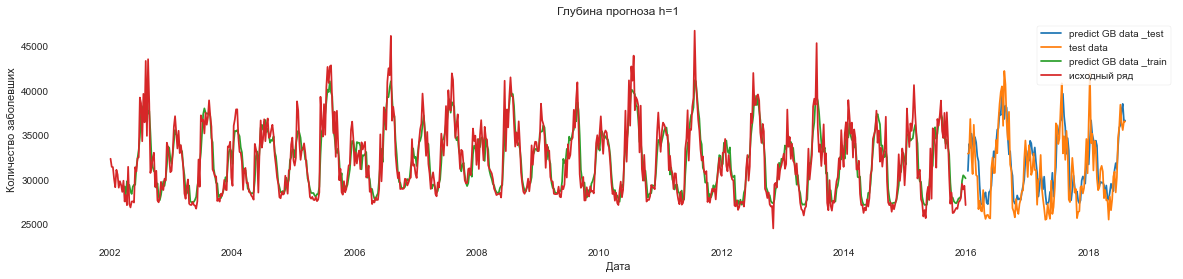

ошибка градиентного бустинга :   6.1580950251883655 %
r2 score :   0.6599980689129288 %


In [27]:
h_list = [1]

for h in h_list:
    X_train_b = train_b.iloc[p:-h,:]
    y_train_b = train_b['PJME_MW'].values[h+p:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b['PJME_MW'].values[h:]

    model_lgbm.fit( X_train_b, y_train_b ) 
    Y_test_pred_gb = model_lgbm.predict(X_test_b)
    Y_train_pred_gb = model_lgbm.predict(X_train_b)

    plt.figure( figsize=( 20, 4 ))

    plt.title(f'Глубина прогноза h={h}')
    plt.xlabel('Дата')
    plt.ylabel('Количество заболевших')
    plt.plot(test_b.index[h:], Y_test_pred_gb, label='predict GB data _test' )
    plt.plot(test_b.index[h:], y_test_b, label='test data')
    
    plt.plot(train_b.index[h+p:], Y_train_pred_gb, label='predict GB data _train')
    
    plt.plot(data_W.loc[:'01/01/2016'].index, data_W.loc[:'01/01/2016']['PJME_MW'], label='исходный ряд')
    
    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=Y_test_pred_gb)
    er_r2 = r2_score(y_true=y_test_b, y_pred=Y_test_pred_gb)

    print('ошибка градиентного бустинга :  ', er_g, '%')
    print('r2 score :  ', er_r2, '%')

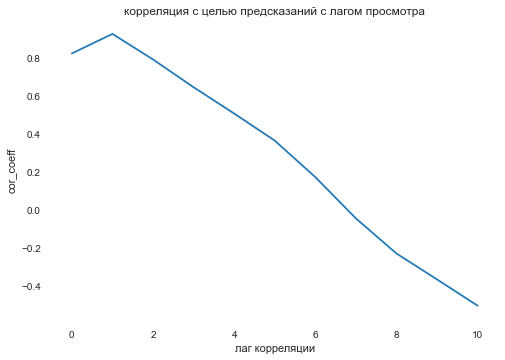

In [28]:
lag=10
p_cor=[np.corrcoef( y_test_b, Y_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], Y_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

#### График корреляций выглядит не хорошо, т.к. на первом лаге у нас почти 1.

### модель предсказания 1-й (была выше, но для сравнения) и 4-й  точки от текущей (h = 1, h = 4)

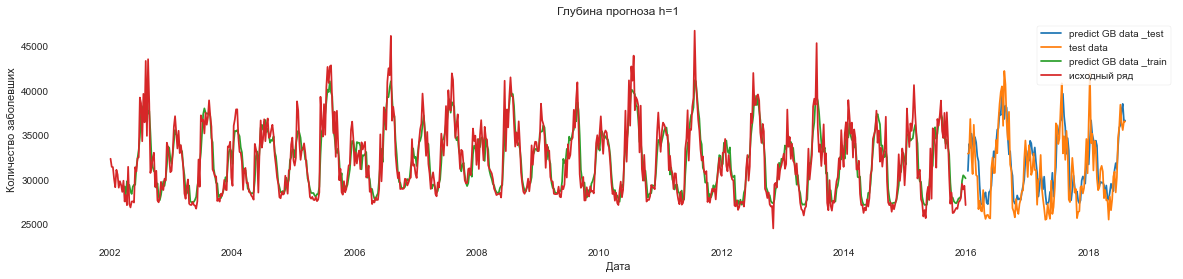

ошибка градиентного бустинга :   6.1580950251883655 %
r2 score :   0.6599980689129288


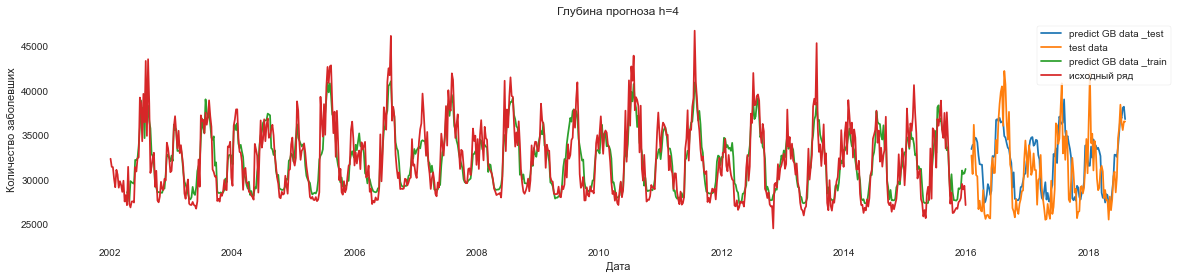

ошибка градиентного бустинга :   7.768999006153492 %
r2 score :   0.4644827339772807


In [29]:
h_list = [1, 4]

for h in h_list:
    X_train_b = train_b.iloc[p:-h,:]
    y_train_b = train_b['PJME_MW'].values[h+p:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b['PJME_MW'].values[h:]

    model_lgbm.fit( X_train_b, y_train_b ) 
    Y_test_pred_gb = model_lgbm.predict(X_test_b)
    Y_train_pred_gb = model_lgbm.predict(X_train_b)

    plt.figure( figsize=( 20, 4 ))

    plt.title(f'Глубина прогноза h={h}')
    plt.xlabel('Дата')
    plt.ylabel('Количество заболевших')
    plt.plot(test_b.index[h:], Y_test_pred_gb, label='predict GB data _test' )
    plt.plot(test_b.index[h:], y_test_b, label='test data')
    
    plt.plot(train_b.index[h+p:], Y_train_pred_gb, label='predict GB data _train')
    
    plt.plot(data_W.loc[:'01/01/2016'].index, data_W.loc[:'01/01/2016']['PJME_MW'], label='исходный ряд')
    
    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=Y_test_pred_gb)
    er_r2 = r2_score(y_true=y_test_b, y_pred=Y_test_pred_gb)

    print('ошибка градиентного бустинга :  ', er_g, '%')
    print('r2 score :  ', er_r2)

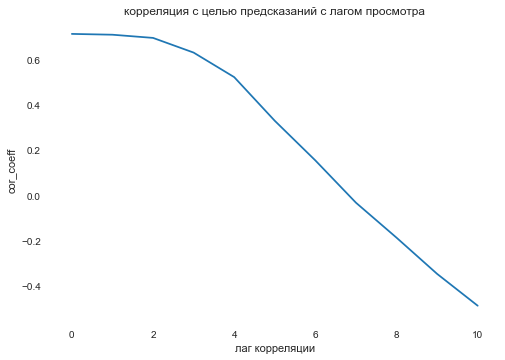

In [30]:
lag=10
p_cor=[np.corrcoef( y_test_b, Y_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], Y_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

#### График корреляций (для h=4) выглядит нормально.

### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек

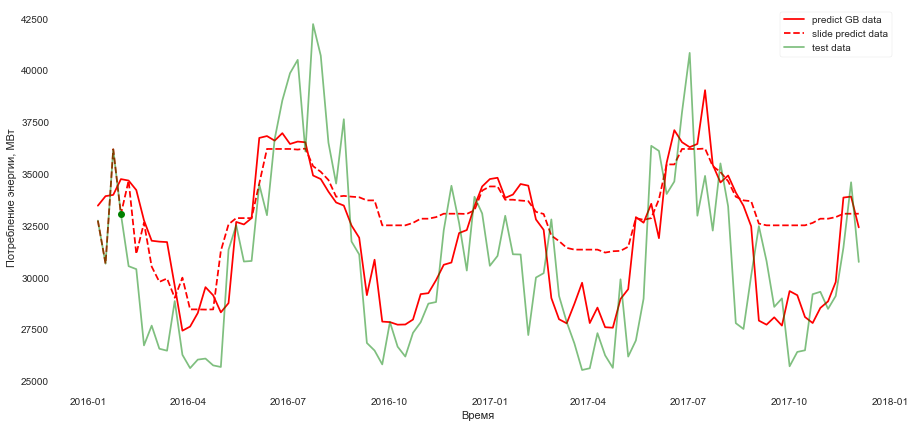

In [31]:
# 'pca2', 'PJME_MW', 'weekofyear', 'exp_0_08', 't3', 'month', 'year', 't1', 't2', 't10', 'd_w4'
X_test_100 = X_test_b.copy()
y_test_100 = y_test_b.copy()
N10 = 100
p = 4
for i in range(p,N10+p):
    y_test_100[i] = model_lgbm.predict(np.array(X_test_100.iloc[i:i+1,:]))
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100['PJME_MW'][i+1] = (y_test_100[i:i+1]-scl_x.mean_[0])/scl_x.scale_[0]
    #строим 'exp_0_08'
    X_test_100['exp_0_08'][i+1] = X_test_100['exp_0_08'][i]*(1-0.08)+ 0.08 * X_test_100['PJME_MW'][i+1] 
    #строим 'd_w4' - признак под номером 3
    X_test_100['d_w4'][i+1] = np.mean(X_test_100['PJME_MW'][i-3:i+1]) 
    # обновим историю значенний
    X_test_100['t1'][i+1] = X_test_100['PJME_MW'][i-1]
    X_test_100['t2'][i+1] = X_test_100['PJME_MW'][i-2]
    X_test_100['t3'][i+1] = X_test_100['PJME_MW'][i-3]
    X_test_100['t10'][i+1] = X_test_100['PJME_MW'][i-10]
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test_b.index[1:N10+1],Y_test_pred_gb[:N10], 'r',label='predict GB data' )
plt.plot(test_b.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test_b.index[1:N10+1],y_test_b[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test_b.index[p],y_test_b[p-1], 'og', alpha=1)
plt.legend()
plt.show()   

In [32]:
er_g_sl = mean_absolute_percentage_error(y_true=y_test_b[p:p+4], y_pred=y_test_100[p:p+4])
er_g_gb = mean_absolute_percentage_error(y_true=y_test_b[p:p+4], y_pred=Y_test_pred_gb[p:p+4])
print(f'slide - ошибка градиентного бустинга MAPE : {er_g_sl},%')
print(f'lightGBM - ошибка градиентного бустинга MAPE : {er_g_gb},%')

slide - ошибка градиентного бустинга MAPE : 12.089908552861715,%
lightGBM - ошибка градиентного бустинга MAPE : 15.858465958284409,%


#### Путем рекурсивного моделирования на длине выборки из 4-х точек результат получился точнее чем напрямую

### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [33]:
for i in range(10):
    #er_g = mean_absolute_percentage_error(y_true=y_test_b[p:N10],y_pred = y_test_100[p:N10])
    er_g = mean_absolute_percentage_error(y_true=y_test_b[1+p+i*10:10+p+i*10],y_pred = y_test_100[1+p+i*10:10+p+i*10])
    print(f'ошибка градиентного бустинга MAPE, точки от {1+i*10} до {10+i*10} : {er_g},%')

ошибка градиентного бустинга MAPE, точки от 1 до 10 : 10.579042155742952,%
ошибка градиентного бустинга MAPE, точки от 11 до 20 : 6.878924137094337,%
ошибка градиентного бустинга MAPE, точки от 21 до 30 : 8.184551104275481,%
ошибка градиентного бустинга MAPE, точки от 31 до 40 : 21.49504004301609,%
ошибка градиентного бустинга MAPE, точки от 41 до 50 : 5.2982719856684914,%
ошибка градиентного бустинга MAPE, точки от 51 до 60 : 12.894464789718821,%
ошибка градиентного бустинга MAPE, точки от 61 до 70 : 14.607744989897938,%
ошибка градиентного бустинга MAPE, точки от 71 до 80 : 7.589543585062791,%
ошибка градиентного бустинга MAPE, точки от 81 до 90 : 14.213444507356568,%
ошибка градиентного бустинга MAPE, точки от 91 до 100 : 9.065600360341278,%


#### Ошибка циклически изменяется, если вначале точность была высока, то после первого полугодового цикла, график сильно сгладился и результатк уже не выглядит хорошим.